In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
from numba import njit, prange
from scipy.sparse import csr_matrix

In [2]:
adata = sc.datasets.pbmc3k_processed()
adata = adata.raw.to_adata()
df = adata.to_df()

The ranking function should be:  
- accept sparse matrix
- return the ranked matrix without creating a dense version of the input matrix
- parallelizable
- and CPU heavy parts should be compiled

# 1. Rank the Input Vector

## 1.1 Ranking Function from Scipy
[Scipy Implementation](https://github.com/scipy/scipy/blob/v1.10.0/scipy/stats/_stats_py.py#L9397-L9541)

In [3]:
def rankdata(a, method='average', *, axis=None, nan_policy='propagate'):

    if method not in ('average', 'min', 'max', 'dense', 'ordinal'):
        raise ValueError('unknown method "{0}"'.format(method))

    a = np.asarray(a)

    if axis is not None:
        if a.size == 0:
            # The return values of `normalize_axis_index` are ignored.  The
            # call validates `axis`, even though we won't use it.
            # use scipy._lib._util._normalize_axis_index when available
            np.core.multiarray.normalize_axis_index(axis, a.ndim)
            dt = np.float64 if method == 'average' else np.int_
            return np.empty(a.shape, dtype=dt)
        return np.apply_along_axis(rankdata, axis, a, method,
                                   nan_policy=nan_policy)

    arr = np.ravel(a)
    contains_nan, nan_policy = _contains_nan(arr, nan_policy)
    nan_indexes = None
    if contains_nan:
        if nan_policy == 'omit':
            nan_indexes = np.isnan(arr)
        if nan_policy == 'propagate':
            return np.full_like(arr, np.nan)

    algo = 'mergesort' if method == 'ordinal' else 'quicksort'
    sorter = np.argsort(arr, kind=algo)

    inv = np.empty(sorter.size, dtype=np.intp)
    inv[sorter] = np.arange(sorter.size, dtype=np.intp)

    if method == 'ordinal':
        result = inv + 1

    arr = arr[sorter]
    obs = np.r_[True, arr[1:] != arr[:-1]]
    dense = obs.cumsum()[inv]

    if method == 'dense':
        result = dense

    # cumulative counts of each unique value
    count = np.r_[np.nonzero(obs)[0], len(obs)]

    if method == 'max':
        result = count[dense]

    if method == 'min':
        result = count[dense - 1] + 1

    if method == 'average':
        result = .5 * (count[dense] + count[dense - 1] + 1)

    if nan_indexes is not None:
        result = result.astype('float64')
        result[nan_indexes] = np.nan

    return 

## 1.2 Implement a Minimal Version of Scipy's Function to Compile with Numba

In [4]:
@njit
def minimal_ranker(arr, ascending=False):
    arr = np.ravel(arr)
    sorter = np.argsort(arr, kind='quicksort')

    inv = np.empty(sorter.size, dtype=np.intp)
    inv[sorter] = np.arange(sorter.size, dtype=np.intp)

    arr = arr[sorter]
    obs = np.hstack((np.array([True]), arr[1:] != arr[:-1]))

    count = np.hstack((np.nonzero(obs)[0], np.array([len(obs)])))
    dense = obs.cumsum()[inv]
    result = .5 * (count[dense] + count[dense - 1] + 1)

    if ascending:
        return result
    else:
        return len(result) + 1 - result

## 1.3 Calculate the Rank of Zeros

90-95% of the scRNA-seq expression matrix consists of zeros. Thus, ranks of zero values can be computed beforehand. In this way we can rank only nonzero subset instead of ranking entire vector (~20,000 genes).

In [5]:
@njit
def get_ranks_of_zeros(n_genes, n_nonzero):
    n_zeros = n_genes - n_nonzero
    base_rank = (sum(range(n_genes + 1)) - sum(range(n_nonzero + 1))) / n_zeros
    new_arr = np.full((n_genes,), fill_value=base_rank)
    return new_arr

#### 1.3.1 Create an Example Data

Since UCell ranks genes for each individual cell, we can work on a single cell (vector) for demonstration

In [10]:
# Take the first row (cell) of expression matrix and subsample the genes
cell_dense = df.iloc[0, :].copy()
cell_dense = cell_dense.sample(20, random_state=2)

In [11]:
cell_sparse = csr_matrix(cell_dense)

In [12]:
cell_dense

index
PDCL3           0.000000
DNMT1           0.000000
ADCY7           0.000000
ADAM15          0.000000
ZNF485          0.000000
UBA7            0.693147
TSR3            0.000000
TMOD1           0.000000
GCAT            0.000000
HIST1H4H        0.000000
RP11-36B15.1    0.000000
IRF5            0.000000
TULP3           0.000000
MFSD2B          0.000000
DHRS7B          0.000000
RP11-468E2.5    0.000000
ADCY4           0.000000
FEM1C           0.000000
NOL11           0.693147
KDM5D           0.000000
Name: AAACATACAACCAC-1, dtype: float32

In [13]:
cell_sparse

<1x20 sparse matrix of type '<class 'numpy.float32'>'
	with 2 stored elements in Compressed Sparse Row format>

When we rank the dense vector, we get following output, where all zeros take the rank of 11.5

#### 1.3.2 Calculating the Rank of Zero Values

In [14]:
# How does data looks when we rank it
cell_dense.rank(ascending=False)

index
PDCL3           11.5
DNMT1           11.5
ADCY7           11.5
ADAM15          11.5
ZNF485          11.5
UBA7             1.5
TSR3            11.5
TMOD1           11.5
GCAT            11.5
HIST1H4H        11.5
RP11-36B15.1    11.5
IRF5            11.5
TULP3           11.5
MFSD2B          11.5
DHRS7B          11.5
RP11-468E2.5    11.5
ADCY4           11.5
FEM1C           11.5
NOL11            1.5
KDM5D           11.5
Name: AAACATACAACCAC-1, dtype: float64

We can compute the rank of zero values as following

In [15]:
n_genes = len(cell_dense) # Number of genes
n_nonzero = 2 # Number of non zero elements
n_zeros = n_genes - n_nonzero # Number of zero elements

The rank of zero values will be equal to:

In [16]:
(sum(range(n_genes + 1)) - sum(range(n_nonzero + 1))) / n_zeros

11.5

#### 1.3.3 Rank Nonzero Values

In [17]:
# Rank the nonzero values
nonzero_vals = cell_dense[['NOL11', 'UBA7']]
nonzero_vals

index
NOL11    0.693147
UBA7     0.693147
Name: AAACATACAACCAC-1, dtype: float32

Below, we get the same rank values for nonzero elements

In [18]:
nonzero_vals.rank(ascending=False)

index
NOL11    1.5
UBA7     1.5
Name: AAACATACAACCAC-1, dtype: float64

**We can create the following function to get a vector filled with rank of zero values.**

In the next step we will fill the ranked vector for nonzero values

In [19]:
@njit
def get_ranks_of_zeros(n_genes, n_nonzero):
    n_zeros = n_genes - n_nonzero
    base_rank = (sum(range(n_genes + 1)) - sum(range(n_nonzero + 1))) / n_zeros
    new_arr = np.full((n_genes,), fill_value=base_rank)
    return new_arr

## 1.4 Calculate Ranks of Nonzero Values and Insert into the Vector

In [20]:
cell_sparse

<1x20 sparse matrix of type '<class 'numpy.float32'>'
	with 2 stored elements in Compressed Sparse Row format>

In [21]:
# Calculate ranks of zero values
ranks_of_zeros = get_ranks_of_zeros(n_genes=cell_sparse.shape[1], n_nonzero=cell_sparse.nnz)
ranks_of_zeros

array([11.5, 11.5, 11.5, 11.5, 11.5, 11.5, 11.5, 11.5, 11.5, 11.5, 11.5,
       11.5, 11.5, 11.5, 11.5, 11.5, 11.5, 11.5, 11.5, 11.5])

Now we can insert the ranks of nonzero values into this array with our "minimal_ranker" function

In [22]:
@njit
def insert_ranks_of_nonzero(base_rank_arr, nonzero_arr, csr_indices):
    rnk = minimal_ranker(nonzero_arr)
    base_rank_arr[csr_indices] = rnk

In [23]:
insert_ranks_of_nonzero(ranks_of_zeros,
                        nonzero_arr=cell_sparse[:, cell_sparse.indices].toarray(), # we get the nonzero subset
                        csr_indices=cell_sparse.indices # indices attribute stores the location of nonzero elements
                       )

In [24]:
ranks_of_zeros # ranks of nonzero elements are inserted in place

array([11.5, 11.5, 11.5, 11.5, 11.5,  1.5, 11.5, 11.5, 11.5, 11.5, 11.5,
       11.5, 11.5, 11.5, 11.5, 11.5, 11.5, 11.5,  1.5, 11.5])

A top level function that accepts a sparse matrix and returns ranked array

In [25]:
def rank_sparse(sp_arr):
    new_arr = get_ranks_of_zeros(sp_arr.shape[1], sp_arr.nnz)
    insert_ranks_of_nonzero(new_arr, sp_arr[:, sp_arr.indices].toarray(), sp_arr.indices)
    return new_arr

# 2. Calculate U Score

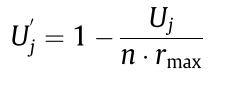

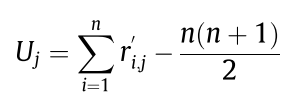

In [26]:
def _calculate_u_score(vec, # The input vector 
                       max_rank, # maxRank in the original R implementation
                       n_signature, # number of genes in the signature list
                       idx, # indices of the signature genes
                      ):
    rnk = rank_sparse(vec)
    rnk[rnk > max_rank] = max_rank + 1
    rnk = rnk[idx]
    u_val = sum([i - (n_signature * (n_signature + 1)) / 2 for i in rnk])
    auc = 1 - (u_val / (n_signature * max_rank))
    return auc

**Top Level Function of UCell**

In [28]:
def score_genes_ucell(adata, signature, max_rank=1500, score_name='ucell_score',  copy=False):
    adata = adata.copy() if copy else adata
    n_signature = len(signature)
    idx = [adata.var.index.to_list().index(s) for s in signature]

    res = map(lambda vec: _calculate_u_score(vec, max_rank=max_rank, n_signature=n_signature, idx=idx), [vec for vec in adata.X])
    adata.obs[score_name] = list(res)
    return adata if copy else None


# 3. Calculate an Example

In [29]:
score_genes_ucell(adata, signature=['CD79A', 'MS4A1', 'CD19'])

C:\Users\ergun\pycharm\ucell\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


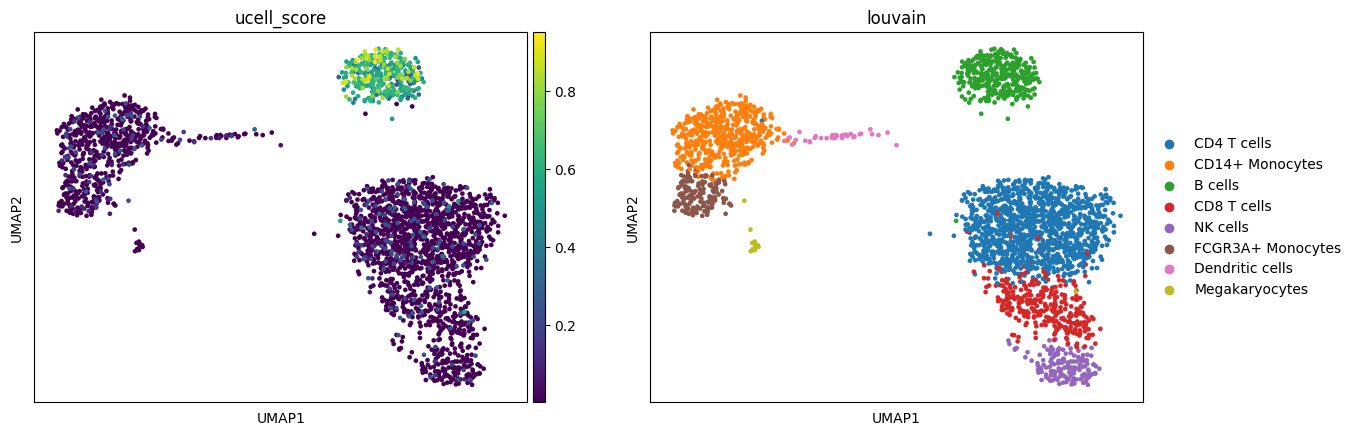

In [31]:
sc.pl.umap(adata, color=['ucell_score', 'louvain'])

## Current limitations

- KNN smoothing is not available
- Negative weighting is not available
- Calculates signature score for a unique population. It can accept a dictionary to calculate scores for B cells, T cells and so on.